In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
from backtester.data_handler import DataHandler
from backtester.backtester import Backtester
from backtester.metrics import Metrics
from backtester.strategy import Strategy
from backtester.plot import ChartPlotter

In [3]:
SYMBOLS = ['EURUSD', 'GBPUSD', 'USDJPY']
TIMEFRAME = mt5.TIMEFRAME_H1
BARS = 1000
INITIAL_CAPITAL = 10000
LEVERAGE = 10
TRANSACTION_COST = 0.001
CAPITAL_PER_TRADE = 0.1
SPREAD_PERCENT = 0.03  # Spread between entry and TP/SL
TP_SL_RATIO = 2  # Ratio between TP and SL

In [4]:
class MACDStrategy(Strategy):
    def __init__(self, fast_period, slow_period, signal_period):
        self.fast_period = fast_period
        self.slow_period = slow_period
        self.signal_period = signal_period

    def should_enter_trade(self, symbol_data, index):
        macd_line = symbol_data['macd_line'].iloc[index]
        signal_line = symbol_data['signal_line'].iloc[index]
        if macd_line > signal_line:
            return 'long'
        elif macd_line < signal_line:
            return 'short'
        return None

    def should_exit_trade(self, open_position, symbol_data, index):
        macd_line = symbol_data['macd_line'].iloc[index]
        signal_line = symbol_data['signal_line'].iloc[index]
        if (open_position['position'] == 'long' and macd_line < signal_line) or \
           (open_position['position'] == 'short' and macd_line > signal_line):
            return True
        return False

In [5]:
data_handler = DataHandler(SYMBOLS, TIMEFRAME, BARS)
data = data_handler.fetch_data()
data['EURUSD']

,time,open,high,low,close,tick_volume,spread,real_volume
0,2024-07-10 21:00:00,1.08221,1.08252,1.08174,1.08250,1132,0,0
1,2024-07-10 22:00:00,1.08249,1.08296,1.08238,1.08288,891,0,0
2,2024-07-10 23:00:00,1.08288,1.08297,1.08274,1.08289,561,0,0
3,2024-07-11 00:00:00,1.08273,1.08294,1.08253,1.08286,161,8,0
4,2024-07-11 01:00:00,1.08294,1.08332,1.08294,1.08328,372,0,0
...,...,...,...,...,...,...,...,...
995,2024-09-06 08:00:00,1.11159,1.11186,1.11139,1.11169,1030,1,0
996,2024-09-06 09:00:00,1.11168,1.11209,1.11140,1.11207,1555,0,0
997,2024-09-06 10:00:00,1.11207,1.11207,1.11108,1.11158,2276,0,0
998,2024-09-06 11:00:00,1.11158,1.11206,1.11129,1.11174,1939,0,0


In [6]:
# Calculate MACD for each symbol
for symbol, df in data.items():
    df['macd_line'] = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
    df['signal_line'] = df['macd_line'].ewm(span=9, adjust=False).mean()

In [7]:
macd_strategy = MACDStrategy(fast_period=12, slow_period=26, signal_period=9)
backtester = Backtester(initial_capital=INITIAL_CAPITAL, leverage=LEVERAGE, transaction_cost=TRANSACTION_COST, capital_per_trade=CAPITAL_PER_TRADE)
trades_df = backtester.run_backtest(data, macd_strategy)

In [8]:
trades_df['capital'] = INITIAL_CAPITAL + trades_df['pnl'].cumsum()
trades_df

,symbol,entry_time,exit_time,entry_price,close_price,pnl,max_drawdown,tp,sl,position,capital
0,EURUSD,2024-07-10 22:00:00,2024-07-10 22:00:00,1.08288,1.08672,3.740000e+01,5.100000e+01,1.115366,1.066637,long,10037.400000
1,EURUSD,2024-07-12 00:00:00,2024-07-12 00:00:00,1.08663,1.08852,-1.798443e+01,2.960652e+02,1.054031,1.102929,short,10019.415574
2,EURUSD,2024-07-12 13:00:00,2024-07-12 13:00:00,1.08900,1.08898,-9.738811e-01,9.105788e+01,1.121670,1.072665,long,10018.441693
3,EURUSD,2024-07-15 01:00:00,2024-07-15 01:00:00,1.08870,1.09129,-1.964543e+01,2.241332e+02,1.056039,1.105031,short,9998.796262
4,EURUSD,2024-07-15 13:00:00,2024-07-15 13:00:00,1.09098,1.08947,-1.055061e+01,8.650191e+01,1.123709,1.074615,long,9988.245650
...,...,...,...,...,...,...,...,...,...,...,...
200,USDJPY,2024-09-02 12:00:00,2024-09-02 12:00:00,146.67800,146.89400,-3.038407e-08,-6.234435e-07,151.078340,144.477830,long,9990.247742
201,USDJPY,2024-09-02 21:00:00,2024-09-02 21:00:00,146.90500,145.07500,-2.873730e-07,-2.335073e-06,142.497850,149.108575,short,9990.247742
202,USDJPY,2024-09-04 14:00:00,2024-09-04 14:00:00,144.88700,145.07200,7.935454e-08,-7.239655e-06,140.540390,147.060305,short,9990.247742
203,USDJPY,2024-09-04 16:00:00,2024-09-04 16:00:00,144.78900,143.83100,-2.935830e-07,-5.205665e-06,140.445330,146.960835,short,9990.247742


In [9]:
metrics = Metrics()
performance_summary = metrics.calculate_metrics(trades_df, initial_capital=INITIAL_CAPITAL)

# Convert the performance summary into a DataFrame for display
summary_df = pd.DataFrame(list(performance_summary.items()), columns=['Metric', 'Value'])
summary_df

,Metric,Value
0,Initial Capital,10000.000000
1,Final Capital,9990.247742
2,Maximum Capital,10037.400000
3,Minimum Capital,9971.005403
4,Volatility (Ann.),61.960087
5,Sharpe Ratio,-0.193482
6,Max Drawdown,296.065224
7,Avg Drawdown,10.116883
8,# Trades,205.000000
9,Win Rate,0.429268


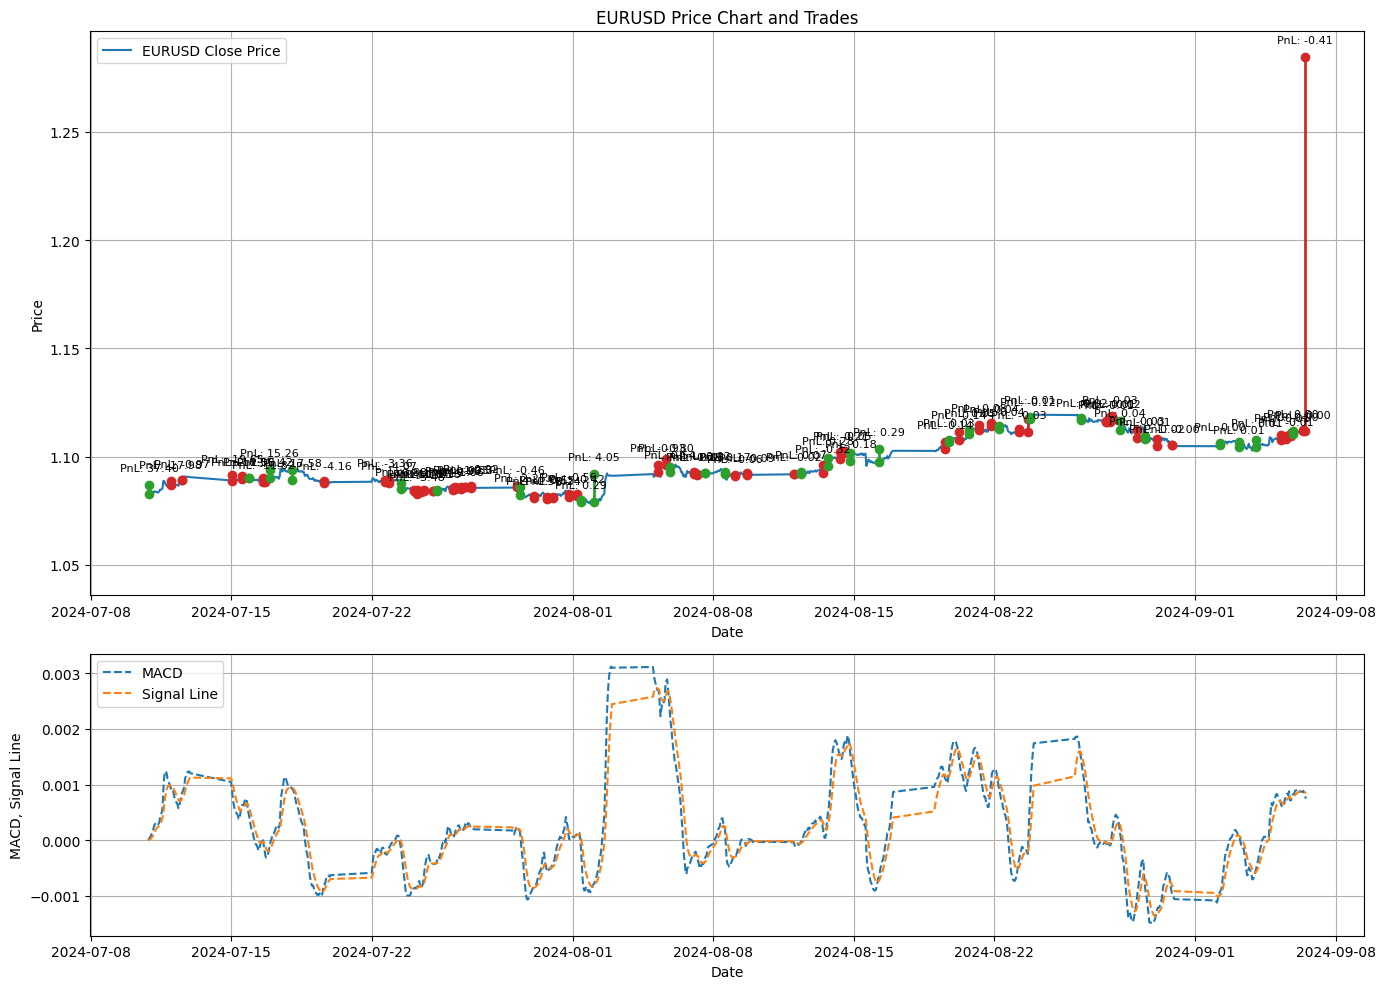

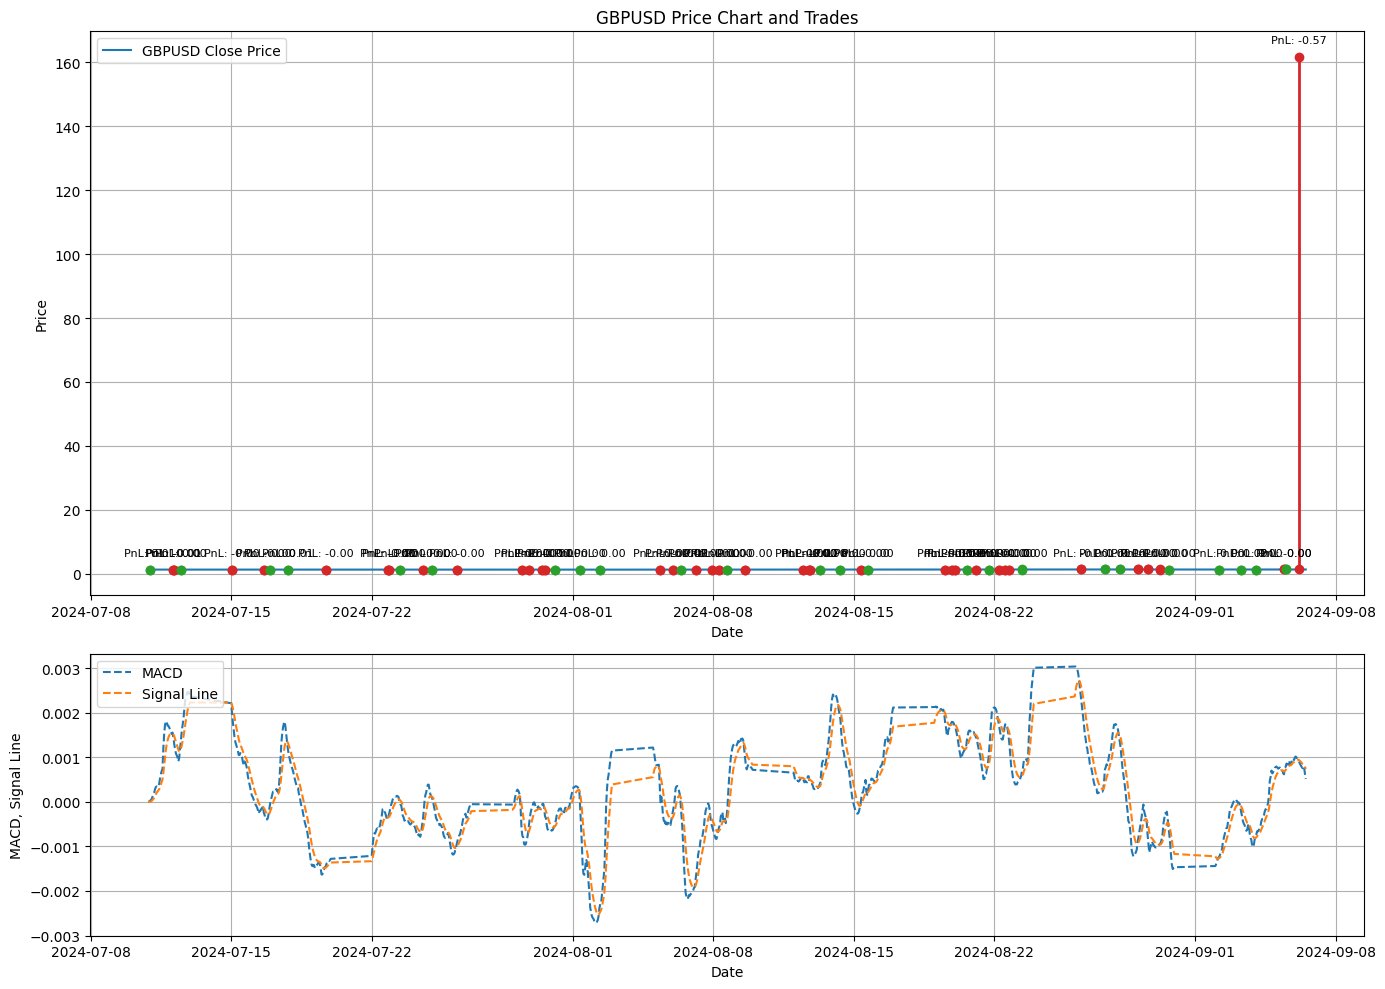

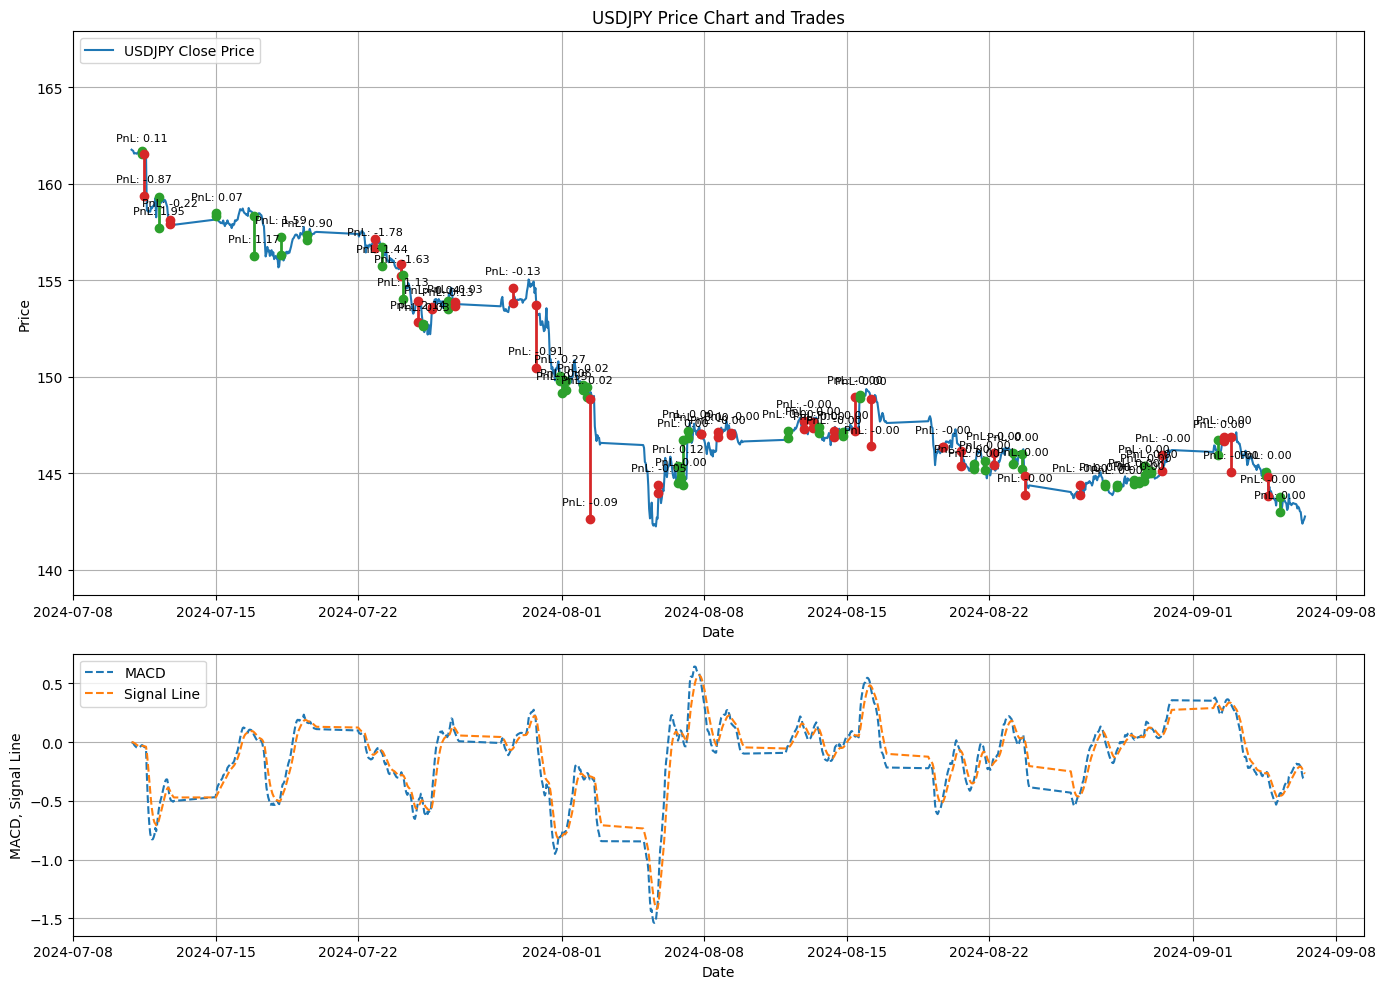

In [10]:
chart_plotter = ChartPlotter(
    trades_df=trades_df,
    shared_data=data,
    indicators={'MACD': 'macd_line', 'Signal Line': 'signal_line'}  # Example for MACD strategy
)

# Plot trades and indicators for all symbols
chart_plotter.plot_trades_for_all_symbols()